# Tutorial for batch processing in `expsolve`

We illustrate this with `expsolve.fourier`, which is imported as `ex`.

Batch processing is built-in in `expsolve` from ground up. This notebook demonstrates how to use it in practice.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, cos, abs, real, imag, pi
from torch.linalg import matrix_exp

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

## Solving the Schrodinger equation, when initial conditions are in a batch

### Creating and visualizing a random batch of initial conditions

In [3]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr).to(device)

V = x**4 - 10*x**2

def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))    
    u = ex.normalize(u, xr)
    return u

N = 1000
urlist = [ugen(sx0=1.0, svar=0.3, sw0=0.1) for _ in range(N)]
urtensor = torch.stack([ur.flatten() for ur in urlist]) 

In [ ]:
#v = V.to(device)
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)

strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


### Observables

In [5]:
T = 1
Nstep = 100
timegrid = es.timegrid([0,T], Nstep)

observables = {'energy': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + V*psi, u, xr), 
'position': lambda u: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u: ex.observable(lambda psi: V*psi, u, xr)}

uTbatch, obsvalues_batch, uintermediate_batch = es.solvediffeq(urtensor, timegrid, strangstep, observables=observables)

NameError: name 'strangstep' is not defined

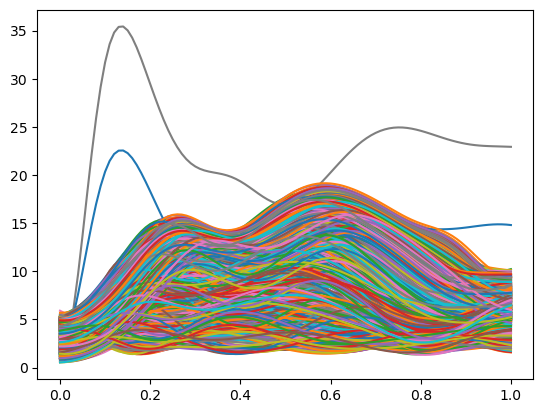

In [19]:
ex.plot(plt, timegrid, obsvalues_batch['kinetic'], separatelines=True)

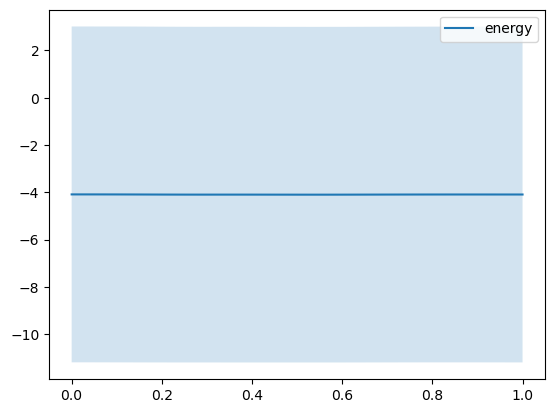

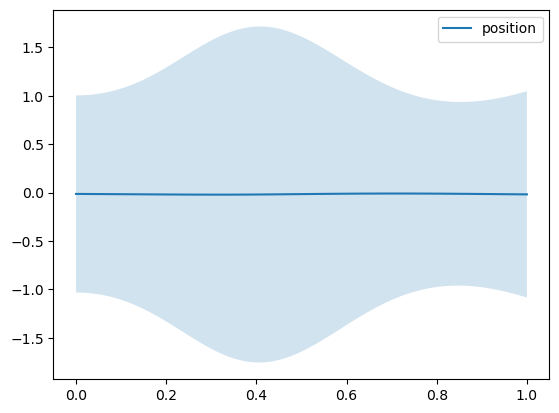

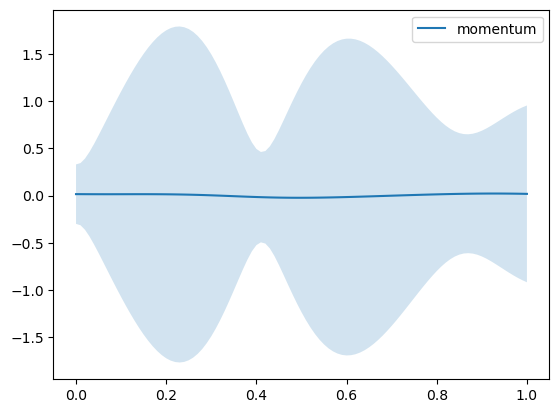

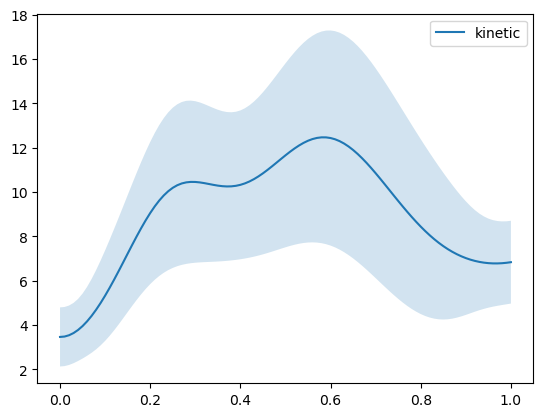

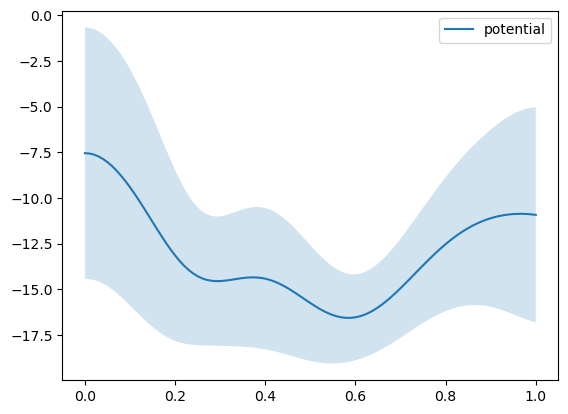

In [20]:
for o in observables:
    ov = obsvalues_batch[o]
    plt.figure()
    ex.plot(plt, timegrid, ov)   
    plt.legend([o])
    plt.show()